In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 1. 데이터 불러오기
file_path = "../data/processed/Customer_Churn_Dataset_0_impute_onehot.csv"
df = pd.read_csv(file_path)

# 2. 불필요한 컬럼 제거 (인덱스 컬럼 등)
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

# 3. 문제지(X)와 정답지(y) 나누기
target = 'Churn'  # 타겟 컬럼명 확인 필수
X = df.drop(columns=[target])
y = df[target]

# 4. 데이터 분할 (Train: 75%, Test: 25%)
# stratify=y 옵션은 이탈 고객의 비율을 유지하며 나누기 위해 필수입니다.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.25, random_state=0
)

# 잘 나뉘었는지 크기 확인
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)

X_train: (5282, 21)
X_test: (1761, 21)


In [ ]:
# 중복 값

# from sklearn.metrics import classification_report
# import pandas as pd

# low_to_high_feats = list(fi.index[::-1])

# results = []
# dropped = []

# for k, feat in enumerate(low_to_high_feats):
#     dropped.append(feat)

#     X_train_sub = X_train.drop(columns=dropped)
#     X_test_sub  = X_test.drop(columns=dropped)
#     if X_train_sub.shape[1] < 1:
#         break

#     model = DecisionTreeClassifier(
#         max_depth=5,
#         class_weight='balanced',
#         random_state=42
#     )
#     model.fit(X_train_sub, y_train)
#     y_pred = model.predict(X_test_sub)

#     report = classification_report(y_test, y_pred, output_dict=True)
#     f1_1 = report["1"]["f1-score"]
#     recall_1 = report["1"]["recall"]

#     results.append({
#         "제거_개수": k + 1,
#         "제거한_피처": feat,
#         "누적_제거_리스트": dropped.copy(),
#         "남은_피처수": X_train_sub.shape[1],
#         "f1_클래스1": f1_1,
#         "recall_클래스1": recall_1
#     })

# df_results = pd.DataFrame(results)
# df_results


In [193]:
from sklearn.metrics import classification_report
import pandas as pd

# 중요도 낮은 피처 목록 (원하는 대로 수정 가능)
feature_list = [
    "gender",
    "SeniorCitizen",
    "Partner",
    "Dependents",
    "PhoneService",
    "MultipleLines",
    "StreamingTV",
    "StreamingMovies",
    "PaperlessBilling",
    "PaymentMethod",
    "numAdminTickets"
]

results = []

for feat in feature_list:
    # 1개만 뺀 버전으로 학습 (feat 하나만 drop)
    X_train_sub = X_train.drop(columns=[feat])
    X_test_sub  = X_test.drop(columns=[feat])

    model = DecisionTreeClassifier(max_depth=5,
                                   class_weight='balanced',
                                   random_state=42)
    model.fit(X_train_sub, y_train)
    y_pred = model.predict(X_test_sub)

    # 클래스 1의 f1-score / recall만 꺼내기
    report = classification_report(y_test, y_pred, output_dict=True)
    f1_1 = report["1"]["f1-score"]
    recall_1 = report["1"]["recall"]

    results.append({
        "제거_피처": feat,
        "f1_클래스1": f1_1,
        "recall_클래스1": recall_1
    })

df_results = pd.DataFrame(results)
df_results


,제거_피처,f1_클래스1,recall_클래스1
0,gender,0.700840,0.892934
1,SeniorCitizen,0.700840,0.892934
2,Partner,0.700840,0.892934
3,Dependents,0.700840,0.892934
4,PhoneService,0.700840,0.892934
5,MultipleLines,0.700840,0.892934
6,StreamingTV,0.700840,0.892934
7,StreamingMovies,0.700840,0.892934
8,PaperlessBilling,0.700840,0.892934
9,PaymentMethod,0.700840,0.892934


In [194]:
from sklearn.model_selection import StratifiedKFold
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. 기본 설정
feature_names = X.columns.tolist()

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

all_importances = []   # 각 fold별 중요도 저장

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), start=1):
    print(f"=== Fold {fold} ===")
    X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # 2. 사장님이 쓰시던 DT 설정 그대로 사용
    model = DecisionTreeClassifier(
        max_depth=5,
        class_weight='balanced',
        random_state=42
    )
    model.fit(X_tr, y_tr)

    # 3. Permutation Importance 계산 (F1 기준, 클래스 1)
    result = permutation_importance(
        model,
        X_val,
        y_val,
        n_repeats=10,
        random_state=42,
        scoring="f1"   # 이탈(1) 기준 F1
    )

    # 이번 fold의 중요도 평균값 저장
    all_importances.append(result.importances_mean)

# 4. fold별 결과를 평균/표준편차로 정리
all_importances = np.array(all_importances)  # (n_folds, n_features)

mean_importances = all_importances.mean(axis=0)
std_importances = all_importances.std(axis=0)

perm_df = pd.DataFrame({
    "feature": feature_names,
    "mean_importance": mean_importances,
    "std_importance": std_importances
}).sort_values("mean_importance", ascending=False)

perm_df


=== Fold 1 ===
=== Fold 2 ===
=== Fold 3 ===
=== Fold 4 ===
=== Fold 5 ===


,feature,mean_importance,std_importance
20,numTechTickets,0.152377,0.018124
4,tenure,0.095456,0.039476
14,Contract,0.089430,0.011778
17,MonthlyCharges,0.066074,0.017686
8,OnlineSecurity,0.053948,0.003144
7,InternetService,0.014204,0.013232
10,DeviceProtection,0.004116,0.008232
9,OnlineBackup,0.002681,0.005361
18,TotalCharges,0.001026,0.002664
12,StreamingTV,0.000564,0.000934


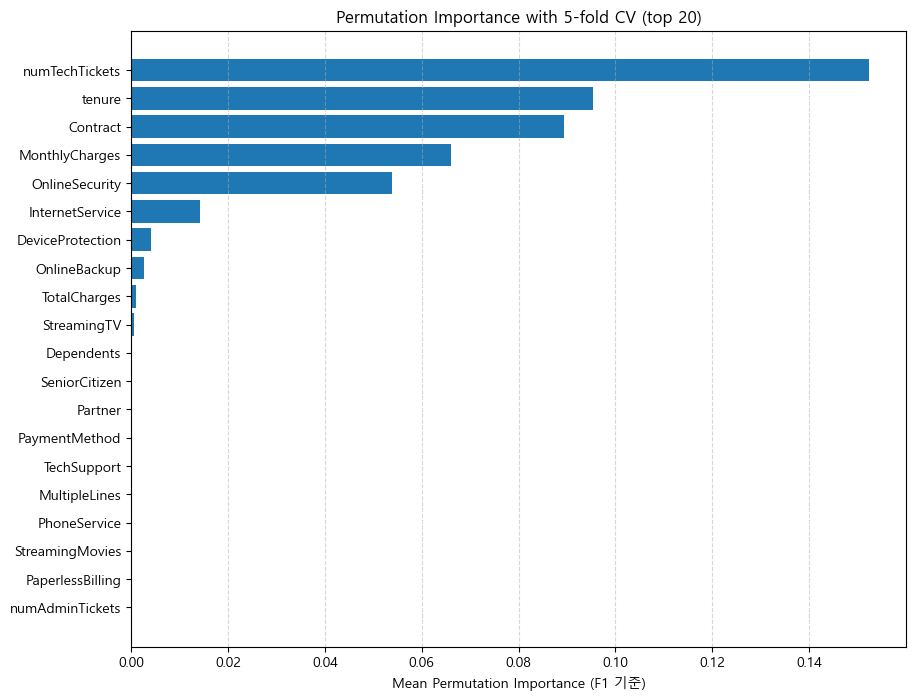

In [195]:
# 상위 N개만 보여주고 싶으면 top_n 조절 (예: 20)
top_n = 20
plot_df = perm_df.head(top_n).iloc[::-1]  # 위에서 N개 가져와서 아래→위 순으로 뒤집기

plt.figure(figsize=(10, 8))
plt.barh(plot_df["feature"], plot_df["mean_importance"])
plt.xlabel("Mean Permutation Importance (F1 기준)")
plt.title(f"Permutation Importance with 5-fold CV (top {top_n})")
plt.grid(True, axis="x", linestyle="--", alpha=0.5)
plt.show()



In [197]:
from sklearn.tree import DecisionTreeClassifier

# 모델 생성
tree = DecisionTreeClassifier(max_depth=5,class_weight='balanced')

# 학습
tree.fit(X_train, y_train)

# 추론
pred_train_tree = tree.predict(X_train)
pred_test_tree = tree.predict(X_test)

In [198]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score
print("DecsionTree 정밀도(Precision) - 1기준")
print(f"Trainset : {precision_score(y_train, pred_train_tree)}, Testset: {precision_score(y_test, pred_test_tree)}")


DecsionTree 정밀도(Precision) - 1기준
Trainset : 0.6049149338374291, Testset: 0.5773480662983426


In [199]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

print("---------------train set Classification Report---------------")
print(classification_report(y_train, pred_train_tree))

---------------train set Classification Report---------------
              precision    recall  f1-score   support

           0       0.96      0.78      0.86      3880
           1       0.60      0.91      0.73      1402

    accuracy                           0.82      5282
   macro avg       0.78      0.85      0.80      5282
weighted avg       0.87      0.82      0.83      5282



In [200]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

print("---------------test set Classification Report---------------")
print(classification_report(y_test, pred_test_tree))

---------------test set Classification Report---------------
              precision    recall  f1-score   support

           0       0.95      0.76      0.85      1294
           1       0.58      0.90      0.70       467

    accuracy                           0.80      1761
   macro avg       0.77      0.83      0.77      1761
weighted avg       0.85      0.80      0.81      1761



In [184]:
tree.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.14870457,
       0.        , 0.        , 0.04778349, 0.05625223, 0.        ,
       0.01404347, 0.        , 0.        , 0.        , 0.4155829 ,
       0.        , 0.        , 0.03587068, 0.00687561, 0.        ,
       0.27488706])

In [159]:
fi = pd.Series(tree.feature_importances_, index=X.columns).sort_values(ascending=False)
fi

Contract            0.415583
numTechTickets      0.274887
tenure              0.148705
OnlineSecurity      0.056252
InternetService     0.051525
MonthlyCharges      0.032129
TechSupport         0.014043
TotalCharges        0.006876
gender              0.000000
Dependents          0.000000
Partner             0.000000
SeniorCitizen       0.000000
MultipleLines       0.000000
StreamingTV         0.000000
DeviceProtection    0.000000
OnlineBackup        0.000000
PhoneService        0.000000
PaymentMethod       0.000000
PaperlessBilling    0.000000
StreamingMovies     0.000000
numAdminTickets     0.000000
dtype: float64

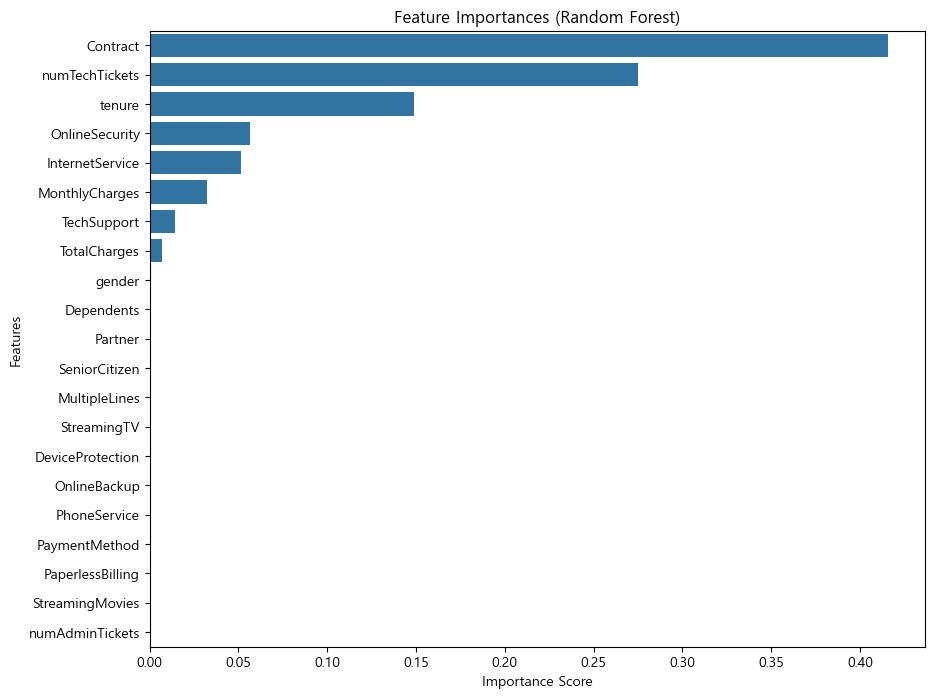

In [148]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. 중요도와 변수명을 묶어서 데이터프레임 만들기
# (rf_model 대신 사용하신 모델 변수명을 넣으세요. 예: rf, tree 등)
importances = tree.feature_importances_
feature_names = X_train.columns

# 보기 좋게 정렬하기 위해 Series로 변환
ft_series = pd.Series(importances, index=feature_names)
ft_series = ft_series.sort_values(ascending=False)  # 내림차순 정렬

# 2. 시각화 그리기
plt.figure(figsize=(10, 8))  # 그림 사이즈 조절 (가로, 세로)
plt.title("Feature Importances (Random Forest)")

# seaborn을 이용해 가로 막대 그래프 그리기
sns.barplot(x=ft_series, y=ft_series.index)

# 라벨 달기
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

In [202]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, f1_score
import pandas as pd

top5 = ["numTechTickets", "tenure", "Contract", "MonthlyCharges", "OnlineSecurity"]

X_train_top5 = X_train[top5]
X_test_top5  = X_test[top5]

params = {
    "max_depth": [3, 5, 7, 10, None],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 4, 8],
    "criterion": ["gini", "entropy"],
    "class_weight": [None, "balanced", {0:1, 1:2}, {0:1, 1:3}]
}

best_f1 = -1
best_model = None
best_setting = None

for depth in params["max_depth"]:
    for split in params["min_samples_split"]:
        for leaf in params["min_samples_leaf"]:
            for cri in params["criterion"]:
                for cw in params["class_weight"]:

                    model = DecisionTreeClassifier(
                        max_depth=depth,
                        min_samples_split=split,
                        min_samples_leaf=leaf,
                        criterion=cri,
                        class_weight=cw,
                        random_state=42
                    )
                    model.fit(X_train_top5, y_train)
                    pred = model.predict(X_test_top5)
                    f1 = f1_score(y_test, pred)

                    if f1 > best_f1:
                        best_f1 = f1
                        best_model = model
                        best_setting = {
                            "max_depth": depth,
                            "min_samples_split": split,
                            "min_samples_leaf": leaf,
                            "criterion": cri,
                            "class_weight": cw
                        }

print("=== 최적 모델 설정 ===")
print(best_setting)
print(f"최고 F1-score: {best_f1:.4f}")

print("\n=== 최적 모델 Detailed Report ===")
print(classification_report(y_test, best_model.predict(X_test_top5)))


=== 최적 모델 설정 ===
{'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 2, 'criterion': 'gini', 'class_weight': {0: 1, 1: 2}}
최고 F1-score: 0.7239

=== 최적 모델 Detailed Report ===
              precision    recall  f1-score   support

           0       0.94      0.82      0.88      1294
           1       0.63      0.85      0.72       467

    accuracy                           0.83      1761
   macro avg       0.78      0.83      0.80      1761
weighted avg       0.86      0.83      0.84      1761

